Load in packages

In [19]:
#!conda install -c conda-forge wikipedia --yes
#!conda install -c conda-forge lxml --yes
#!conda update -n base -c defaults conda
#!conda install -c conda-forge geocoder --yes
#!conda install -c conda-forge pgeocode --yes

import pandas as pd
import wikipedia as wp
import pandas as pd
from geopy.geocoders import Nominatim

import folium
import requests # library to handle requests
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.



PackagesNotFoundError: The following packages are not available from current channels:

  - pgeocode

Current channels:

  - https://conda.anaconda.org/conda-forge/win-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




Using the Wiki package, load in the requested wikipedia page and grab the table in the next cell.

In [3]:
html = wp.page("Huntsville, Alabama").html().encode("UTF-8")

In [4]:
df = pd.read_html(html, flavor='html5lib')[0]
df

,"Huntsville, Alabama","Huntsville, Alabama.1"
0,City,City
1,City of Huntsville,City of Huntsville
2,Clockwise from top: Skyline from Big Spring Pa...,Clockwise from top: Skyline from Big Spring Pa...
3,"Nickname(s): ""Rocket City""","Nickname(s): ""Rocket City"""
4,"Motto(s): ""Star of Alabama""","Motto(s): ""Star of Alabama"""
5,Location of Huntsville in Limestone County and...,Location of Huntsville in Limestone County and...
6,"Huntsville, AlabamaLocation in the United States","Huntsville, AlabamaLocation in the United States"
7,Coordinates: 34°43′48″N 86°35′6″W﻿ / ﻿34.73000...,Coordinates: 34°43′48″N 86°35′6″W﻿ / ﻿34.73000...
8,Country,United States
9,State,Alabama


Find which html cell contains the list of zipcodes, in this case it's index 35.

In [5]:
zipCodeList = df.iloc[35][1]
zipCodeList = zipCodeList.split(", ")
print(zipCodeList)

['35649', '35749', '35748', '35754', '35756', '35757', '35671', '35741', '35762', '35763', '35773', '35801–35816', '35824', '35893-35899']


In [14]:
fullZipList = []
for zipC in zipCodeList:
    if zipC.find("–") != -1 or zipC.find("-") != -1: #For some reason, the dashes are different...
        zipC = zipC.replace("-", "–") #Replace so the split works. This is just a weird result of the data entry on wikipedia I guess
        min_max = zipC.split("–")
        currZip = int(min_max[0])
        maxZip = int(min_max[1])
        while currZip <= maxZip:
            fullZipList.append(currZip)
            currZip += 1 
    else:
        fullZipList.append(int(zipC))
        
            
print(fullZipList)
                       
        
                           
        
    
                       


[35649, 35749, 35748, 35754, 35756, 35757, 35671, 35741, 35762, 35763, 35773, 35801, 35802, 35803, 35804, 35805, 35806, 35807, 35808, 35809, 35810, 35811, 35812, 35813, 35814, 35815, 35816, 35824, 35893, 35894, 35895, 35896, 35897, 35898, 35899]


Remove the Not Assigned rows by identifying indices where the rows are "Not assigned" and in the following cell, remove them by index.

In [31]:
huntsvilleDF = pd.DataFrame({"ZipCodes":fullZipList})
huntsvilleDF["Latitude"] = ""
huntsvilleDF["Longitude"] = ""
huntsvilleDF.head()




,ZipCodes,Latitude,Longitude
0,35649,,
1,35749,,
2,35748,,
3,35754,,
4,35756,,


In [51]:
geolocator = Nominatim(user_agent="Final_Project")
geocode = lambda query: geolocator.geocode("%s, Alabama" % query) #Specifies to only search in Alabama because I got hits in spain earlier with some zip codes.
for i in range(0,huntsvilleDF.shape[0]):
    location = geocode(huntsvilleDF["ZipCodes"][i])
    if(location != None):
        huntsvilleDF["Latitude"][i]=location.latitude
        huntsvilleDF["Longitude"][i]=location.longitude
huntsvilleDF
    

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,ZipCodes,Latitude,Longitude
0,35649,34.6248,-86.8822
1,35749,34.8122,-86.773
2,35748,34.7592,-86.5614
3,35754,34.5194,-86.6079
4,35756,34.5972,-86.777
5,35757,34.7591,-86.7373
6,35671,34.7254,-86.957
7,35741,34.6884,-86.5026
8,35762,29.7251,-95.3554
9,35763,34.6725,-86.4682


Drop non-unique lats and longs and also drop  29.7251 x -95.3554 becuase they are in the wrong place and I believe they are all unused zipcodes that are just assigned to Huntsville.

In [65]:
huntsvilleDF = huntsvilleDF.reset_index().drop_duplicates(subset=['Latitude','Longitude'],keep='first').set_index('index')
huntsvilleDF

,ZipCodes,Latitude,Longitude
index,,,
0,35649,34.6248,-86.8822
1,35749,34.8122,-86.773
2,35748,34.7592,-86.5614
3,35754,34.5194,-86.6079
4,35756,34.5972,-86.777
5,35757,34.7591,-86.7373
6,35671,34.7254,-86.957
7,35741,34.6884,-86.5026
8,35762,29.7251,-95.3554


In [66]:
huntsvilleDF = huntsvilleDF.drop(huntsvilleDF.index[[8]])
huntsvilleDF

,ZipCodes,Latitude,Longitude
index,,,
0,35649,34.6248,-86.8822
1,35749,34.8122,-86.773
2,35748,34.7592,-86.5614
3,35754,34.5194,-86.6079
4,35756,34.5972,-86.777
5,35757,34.7591,-86.7373
6,35671,34.7254,-86.957
7,35741,34.6884,-86.5026
9,35763,34.6725,-86.4682


In [70]:
geolocator = Nominatim(user_agent="Final_Project")
location = geolocator.geocode("Huntsville, Alabama")
lat=location.latitude
long=location.longitude

In [71]:

map_Huntsville = folium.Map(location=[lat, long], zoom_start=11)

# add markers to map
for lat, lng, label in zip(huntsvilleDF['Latitude'], huntsvilleDF['Longitude'], huntsvilleDF['ZipCodes']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Huntsville)  
    
map_Huntsville

In [73]:
CLIENT_ID = 'ZLC3RSY2CARPRMFJ3NBVV3EGSJW2UPR5LZ0F5EZOLVVEYVX1' # your Foursquare ID
CLIENT_SECRET = '0NMN35MBMDCSQFPJBEISF2IC3YCJY2JEQJG0J0ETY3MFHDOJ' # your Foursquare Secret
VERSION = '20200515' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZLC3RSY2CARPRMFJ3NBVV3EGSJW2UPR5LZ0F5EZOLVVEYVX1
CLIENT_SECRET:0NMN35MBMDCSQFPJBEISF2IC3YCJY2JEQJG0J0ETY3MFHDOJ


In [76]:
huntsvilleDF.loc[0, 'ZipCodes']
neighborhood_latitude = huntsvilleDF.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = huntsvilleDF.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = huntsvilleDF.loc[0, 'ZipCodes'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of 35649 are 34.624819957894694, -86.8821504174671.


In [77]:

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius=500&limit=50'.format(CLIENT_ID,
                                                                                                                        CLIENT_SECRET,
                                                                                                                           VERSION,
                                                                                                                       neighborhood_latitude,
                                                                                                                       neighborhood_longitude)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ee00ceae5ec386ad3e47d44'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 34.629319962394696,
    'lng': -86.87669209278154},
   'sw': {'lat': 34.62031995339469, 'lng': -86.88760874215266}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '588c45eefc5a5f18a373bc23',
       'name': 'iTechNomad, Inc.',
       'location': {'address': '24995 Lauderdale St #9',
        'lat': 34.626529693603516,
        'lng': -86.88025665283203,
        'labeledLatLngs': 

In [95]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [96]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,"iTechNomad, Inc.",IT Services,34.626530,-86.880257
1,Limestone Bay Trading Company,Sandwich Place,34.627457,-86.881057
2,Java,Coffee Shop,34.627227,-86.879883


In [97]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


In [98]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCodes', 
                  'ZipCodes Latitude', 
                  'ZipCodes Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [99]:
LIMIT=50
huntsville_venues = getNearbyVenues(names=huntsvilleDF['ZipCodes'],
                                   latitudes=huntsvilleDF['Latitude'],
                                   longitudes=huntsvilleDF['Longitude']
                                  )


35649
35749
35748
35754
35756
35757
35671
35741
35763
35773
35801
35802
35803
35804
35805
35806
35807
35808
35809
35810
35811
35814
35816
35824
35893
35896
35899


In [100]:
huntsville_onehot = pd.get_dummies(huntsville_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
huntsville_onehot['ZipCodes'] = huntsville_venues['ZipCodes'] 

# move neighborhood column to the first column
fixed_columns = [huntsville_onehot.columns[-1]] + list(huntsville_onehot.columns[:-1])
huntsville_onehot = huntsville_onehot[fixed_columns]

huntsville_onehot.head()

,ZipCodes,Adult Boutique,American Restaurant,Antique Shop,Arcade,Asian Restaurant,Auto Dealership,Auto Garage,Bank,Bar,...,Supplement Shop,Tex-Mex Restaurant,Theater,Tourist Information Center,Train Station,Tree,Video Game Store,Video Store,Whisky Bar,Wine Bar
0,35649,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,35649,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,35749,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,35748,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,35748,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
huntsville_grouped = huntsville_onehot.groupby('ZipCodes').mean().reset_index()
huntsville_grouped

,ZipCodes,Adult Boutique,American Restaurant,Antique Shop,Arcade,Asian Restaurant,Auto Dealership,Auto Garage,Bank,Bar,...,Supplement Shop,Tex-Mex Restaurant,Theater,Tourist Information Center,Train Station,Tree,Video Game Store,Video Store,Whisky Bar,Wine Bar
0,35649,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,...,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000
1,35741,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,...,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.166667
2,35748,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,...,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000
3,35749,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,...,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000
4,35757,0.000000,0.071429,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,...,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000
5,35801,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,...,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000
6,35802,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,...,0.000000,0.0000,0.000000,0.00,0.00,0.25,0.000000,0.000000,0.00,0.000000
7,35803,0.000000,0.000000,0.0625,0.000000,0.000000,0.000000,0.0625,0.000000,0.00,...,0.000000,0.0625,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000
8,35804,0.000000,0.000000,0.0400,0.040000,0.000000,0.000000,0.0000,0.000000,0.08,...,0.000000,0.0000,0.000000,0.04,0.08,0.00,0.000000,0.000000,0.04,0.040000
9,35805,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,...,0.000000,0.0000,0.100000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000


In [102]:
huntsville_grouped.shape

num_top_venues = 5

for hood in huntsville_grouped['ZipCodes']:
    #print("----"+hood+"----")
    temp = huntsville_grouped[huntsville_grouped['ZipCodes'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

            venue  freq
0     Coffee Shop   0.5
1  Sandwich Place   0.5
2  Adult Boutique   0.0
3     Men's Store   0.0
4            Park   0.0


               venue  freq
0           Wine Bar  0.17
1         Restaurant  0.17
2       Liquor Store  0.17
3        Pizza Place  0.17
4  Convenience Store  0.17


            venue  freq
0     Dry Cleaner   0.5
1       Speakeasy   0.5
2  Adult Boutique   0.0
3     Men's Store   0.0
4            Park   0.0


              venue  freq
0  Business Service   1.0
1    Adult Boutique   0.0
2       Men's Store   0.0
3         Pet Store   0.0
4              Park   0.0


            venue  freq
0   Grocery Store  0.14
1  Clothing Store  0.14
2     Pizza Place  0.07
3     Event Space  0.07
4  Hardware Store  0.07


            venue  freq
0          Castle   1.0
1  Adult Boutique   0.0
2     Men's Store   0.0
3       Pet Store   0.0
4            Park   0.0


                        venue  freq
0                        Park  0.50
1                     

In [103]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [132]:


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZipCodes']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['ZipCodes'] = huntsville_grouped['ZipCodes']

for ind in np.arange(huntsville_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(huntsville_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,ZipCodes,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,35649,Coffee Shop,Sandwich Place,Donut Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar
1,35741,Wine Bar,Pizza Place,Construction & Landscaping,Convenience Store,Restaurant,Liquor Store,College Arts Building,Cosmetics Shop,Department Store,Diner
2,35748,Dry Cleaner,Speakeasy,Construction & Landscaping,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar,Dog Run
3,35749,Business Service,Wine Bar,Dry Cleaner,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar,Dog Run
4,35757,Grocery Store,Clothing Store,Movie Theater,Department Store,Italian Restaurant,Ice Cream Shop,Event Space,Steakhouse,Pizza Place,Hardware Store


In [133]:
from sklearn.cluster import KMeans
kclusters = 8

huntsville_grouped_clustering = huntsville_grouped.drop('ZipCodes', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(huntsville_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

huntsville_merged = huntsvilleDF

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
huntsville_merged = huntsville_merged.join(neighborhoods_venues_sorted.set_index('ZipCodes'), on='ZipCodes')

huntsville_merged.head() # check the last columns!

,ZipCodes,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
index,,,,,,,,,,,,,,
0,35649,34.6248,-86.8822,1.0,Coffee Shop,Sandwich Place,Donut Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar
1,35749,34.8122,-86.773,3.0,Business Service,Wine Bar,Dry Cleaner,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar,Dog Run
2,35748,34.7592,-86.5614,7.0,Dry Cleaner,Speakeasy,Construction & Landscaping,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar,Dog Run
3,35754,34.5194,-86.6079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,35756,34.5972,-86.777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:

# create map
map_clusters = folium.Map(location=[lat, long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(huntsville_merged['Latitude'], huntsville_merged['Longitude'], huntsville_merged['ZipCodes'], huntsville_merged['Cluster Labels']):
    if np.isnan(cluster):
        continue
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 1 

In [136]:
huntsville_merged.loc[huntsville_merged['Cluster Labels'] == 0]


,ZipCodes,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
index,,,,,,,,,,,,,,
28,35893,34.7228,-86.656,0.0,Café,Wine Bar,Dry Cleaner,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar,Dog Run


Cluster 2

In [149]:
hsv_clust_1 = huntsville_merged.loc[huntsville_merged['Cluster Labels'] == 1]
hsv_clust_1

,ZipCodes,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
index,,,,,,,,,,,,,,
0,35649,34.6248,-86.8822,1.0,Coffee Shop,Sandwich Place,Donut Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar
5,35757,34.7591,-86.7373,1.0,Grocery Store,Clothing Store,Movie Theater,Department Store,Italian Restaurant,Ice Cream Shop,Event Space,Steakhouse,Pizza Place,Hardware Store
7,35741,34.6884,-86.5026,1.0,Wine Bar,Pizza Place,Construction & Landscaping,Convenience Store,Restaurant,Liquor Store,College Arts Building,Cosmetics Shop,Department Store,Diner
12,35802,34.6686,-86.5546,1.0,Park,Construction & Landscaping,Tree,Wine Bar,Donut Shop,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store
13,35803,34.6397,-86.5667,1.0,Fast Food Restaurant,Mexican Restaurant,Sports Bar,Steakhouse,Donut Shop,Ice Cream Shop,Diner,Pizza Place,Buffet,Tex-Mex Restaurant
14,35804,34.736,-86.5871,1.0,Train Station,Dog Run,New American Restaurant,Bar,Wine Bar,Brewery,Gift Shop,Whisky Bar,Hardware Store,Historic Site
15,35805,34.7277,-86.6395,1.0,College Arts Building,Gym,Theater,Pizza Place,Restaurant,Soccer Stadium,Fast Food Restaurant,College Quad,Food,Diner
16,35806,34.7453,-86.6848,1.0,Furniture / Home Store,Shipping Store,Sandwich Place,Discount Store,Hotel,Supplement Shop,Big Box Store,Asian Restaurant,Motel,Mexican Restaurant
19,35809,34.6968,-86.6623,1.0,Golf Course,Basketball Stadium,Sports Bar,German Restaurant,Furniture / Home Store,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store


Cluster 3

In [138]:
huntsville_merged.loc[huntsville_merged['Cluster Labels'] == 2]

,ZipCodes,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
index,,,,,,,,,,,,,,
20,35810,34.8007,-86.6034,2.0,Gym,Home Service,Dry Cleaner,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar,Dog Run
27,35824,34.656,-86.7194,2.0,Gym,College Quad,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop


Cluster 4

In [140]:
huntsville_merged.loc[huntsville_merged['Cluster Labels'] == 3]

,ZipCodes,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
index,,,,,,,,,,,,,,
1,35749,34.8122,-86.773,3.0,Business Service,Wine Bar,Dry Cleaner,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar,Dog Run


In [141]:
huntsville_merged.loc[huntsville_merged['Cluster Labels'] == 4]

,ZipCodes,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
index,,,,,,,,,,,,,,
11,35801,34.7219,-86.5442,4.0,Castle,Wine Bar,Dry Cleaner,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar,Dog Run


In [142]:
huntsville_merged.loc[huntsville_merged['Cluster Labels'] == 5]

,ZipCodes,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
index,,,,,,,,,,,,,,
18,35808,34.6989,-86.6419,5.0,Optical Shop,Wine Bar,College Quad,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar,Dog Run


In [164]:


hsv_clust_1_zipcodes = hsv_clust_1['ZipCodes']

huntsville_grouped_cluster_1 = huntsville_grouped[huntsville_grouped['ZipCodes'].isin(hsv_clust_1_zipcodes)]
huntsville_grouped_cluster_1

neighborhoods_venues_sorted_1 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_1['ZipCodes'] = huntsville_grouped_cluster_1['ZipCodes']

for ind in np.arange(huntsville_grouped_cluster_1.shape[0]):
    neighborhoods_venues_sorted_1.iloc[ind, 1:] = return_most_common_venues(huntsville_grouped_cluster_1.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_1.head()

,ZipCodes,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,35649,Coffee Shop,Sandwich Place,Donut Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar
1,35741,Wine Bar,Pizza Place,Construction & Landscaping,Convenience Store,Restaurant,Liquor Store,College Arts Building,Cosmetics Shop,Department Store,Diner
4,35757,Grocery Store,Clothing Store,Movie Theater,Department Store,Italian Restaurant,Ice Cream Shop,Event Space,Steakhouse,Pizza Place,Hardware Store
6,35802,Park,Construction & Landscaping,Tree,Wine Bar,Donut Shop,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store
7,35803,Fast Food Restaurant,Mexican Restaurant,Sports Bar,Steakhouse,Donut Shop,Ice Cream Shop,Diner,Pizza Place,Buffet,Tex-Mex Restaurant


In [165]:
from sklearn.cluster import KMeans
kclusters = 5

huntsville_grouped_clustering_1 = huntsville_grouped_cluster_1.drop('ZipCodes', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(huntsville_grouped_clustering_1)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted_1.insert(0, 'Cluster Labels', kmeans.labels_)

huntsville_merged_1 = huntsvilleDF[huntsvilleDF['ZipCodes'].isin(hsv_clust_1_zipcodes)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
huntsville_merged_1 = huntsville_merged_1.join(neighborhoods_venues_sorted_1.set_index('ZipCodes'), on='ZipCodes')

huntsville_merged_1.head() # check the last columns!

,ZipCodes,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
index,,,,,,,,,,,,,,
0,35649,34.6248,-86.8822,1,Coffee Shop,Sandwich Place,Donut Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Dive Bar
5,35757,34.7591,-86.7373,0,Grocery Store,Clothing Store,Movie Theater,Department Store,Italian Restaurant,Ice Cream Shop,Event Space,Steakhouse,Pizza Place,Hardware Store
7,35741,34.6884,-86.5026,3,Wine Bar,Pizza Place,Construction & Landscaping,Convenience Store,Restaurant,Liquor Store,College Arts Building,Cosmetics Shop,Department Store,Diner
12,35802,34.6686,-86.5546,4,Park,Construction & Landscaping,Tree,Wine Bar,Donut Shop,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store
13,35803,34.6397,-86.5667,0,Fast Food Restaurant,Mexican Restaurant,Sports Bar,Steakhouse,Donut Shop,Ice Cream Shop,Diner,Pizza Place,Buffet,Tex-Mex Restaurant


In [166]:

# create map
map_clusters = folium.Map(location=[lat, long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(huntsville_merged_1['Latitude'], huntsville_merged_1['Longitude'], huntsville_merged_1['ZipCodes'], huntsville_merged_1['Cluster Labels']):
    if np.isnan(cluster):
        continue
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [167]:
zillowData = pd.read_csv("./Zip_Zhvi_3bedroom.csv")
zillowData

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,986648.0,...,2007896.0,1993949.0,1968856.0,1953742.0,1941274.0,1935334.0,1925941.0,1915756.0,1905328.0,1896771.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,254275.0,...,597981.0,597014.0,595960.0,594385.0,593262.0,592401.0,592454.0,593712.0,595609.0,596617.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,3336572.0,3319051.0,3306346.0,3304358.0,3300321.0,3280484.0,3269709.0,3260471.0,3261451.0,3249109.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,139621.0,...,255803.0,256021.0,256400.0,256655.0,256987.0,257258.0,257261.0,257374.0,257847.0,259022.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,318477.0,...,707451.0,706209.0,704755.0,703530.0,702150.0,700813.0,700371.0,700085.0,700196.0,698759.0
5,91940,5,77449,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,89044.0,...,172680.0,173373.0,173890.0,174487.0,175458.0,176382.0,176924.0,177497.0,178740.0,180268.0
6,61616,6,10002,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,1520366.0,1517964.0,1511079.0,1502233.0,1502641.0,1502752.0,1505575.0,1500884.0,1502380.0,1509329.0
7,91733,7,77084,Zip,TX,TX,Houston,Houston-The Woodlands-Sugar Land,Harris County,88876.0,...,170385.0,170856.0,171234.0,171778.0,172462.0,173145.0,173487.0,174071.0,175060.0,176242.0
8,93144,8,79936,Zip,TX,TX,El Paso,El Paso,El Paso County,79118.0,...,128862.0,129241.0,129347.0,129455.0,129652.0,130177.0,130773.0,131193.0,131376.0,131445.0
9,84640,9,60640,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,199592.0,...,409792.0,410412.0,410013.0,409785.0,409031.0,409158.0,409126.0,409488.0,409701.0,409537.0


In [169]:
hsv_final_cluster = huntsville_merged_1.loc[huntsville_merged_1['Cluster Labels'] == 0]
hsv_fc_zips = hsv_final_cluster["ZipCodes"]
hsv_fc_zips

index
5     35757
13    35803
14    35804
16    35806
24    35814
26    35816
31    35896
Name: ZipCodes, dtype: int64

In [288]:
hsv_cluster_zillowData = zillowData[zillowData["RegionName"].isin(hsv_fc_zips)]
hsv_cluster_zillowData

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30
3250,73619,3316,35806,Zip,AL,AL,Huntsville,Huntsville,Madison County,NaN,...,209981.0,211106.0,212688.0,213929.0,215157.0,216866.0,218998.0,221551.0,224455.0,227053.0
3539,73616,3609,35803,Zip,AL,AL,Huntsville,Huntsville,Madison County,NaN,...,163247.0,164195.0,165575.0,166718.0,167919.0,169560.0,171570.0,174188.0,176884.0,179495.0
6784,73629,6905,35816,Zip,AL,AL,Huntsville,Huntsville,Madison County,NaN,...,99667.0,100738.0,101480.0,101920.0,102401.0,103227.0,104534.0,106354.0,107890.0,109731.0
7366,73595,7500,35757,Zip,AL,AL,Madison,Huntsville,Madison County,NaN,...,171594.0,172544.0,173905.0,175054.0,176238.0,177911.0,179879.0,182401.0,185192.0,187819.0


Some data appears to have been lost but we will just compare these 4 zip codes instead of all of the ones in the cluster.

In [359]:
def getCityDogParks(query,latitude, longitude, radius=500):
    
    venues_list=[]
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT,
        query)
        
    # make the GET request
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    # return only relevant information for each nearby venue
    for v in results:
        try:
            code = v['venue']['location']['postalCode']
            print(code)
            venues_list.append([(
            v['venue']['name'], 
            v['venue']['categories'][0]['name'],
            v['venue']['location']['postalCode'],
            v['venue']['id'])])
        except:
            print("Exception Occured")
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Venue','Venue Category','Venue Zip Code','Venue ID']
    
    return(nearby_venues)

In [360]:
dog_parks = getCityDogParks("dog park",lat, long, radius=30000)
dog_parks

35806
35801
35801
35758
35758
Exception Occured


,Venue,Venue Category,Venue Zip Code,Venue ID
0,Indian Creek Greenway,Trail,35806,4b896decf964a520713532e3
1,Huntsville Dog Park,Dog Run,35801,4be73b02910020a1b434d514
2,The Dog Spot,Dog Run,35801,4bbb23e1935e9521ebca2890
3,Dog Spot,Dog Run,35758,4c06f8900ed3c9280dea787d
4,Mill Creek Geeenway - Dog Park,Dog Run,35758,4dacdd0a93a0faeb8db7a326


In [366]:
url = 'https://api.foursquare.com/v2/venues/{}&client_id={}&client_secret={}&v={}'.format(
    dog_parks['Venue ID'][0],
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
        
    # make the GET request
print(url)    
results = requests.get(url).json()
print(results)

https://api.foursquare.com/v2/venues/4b896decf964a520713532e3&client_id=ZLC3RSY2CARPRMFJ3NBVV3EGSJW2UPR5LZ0F5EZOLVVEYVX1&client_secret=0NMN35MBMDCSQFPJBEISF2IC3YCJY2JEQJG0J0ETY3MFHDOJ&v=20200515
{'meta': {'code': 400, 'errorType': 'invalid_auth', 'errorDetail': 'Missing access credentials. See https://developer.foursquare.com/docs/api/configuration/authentication for details.', 'requestId': '5ee69707ad40e14f6468e20e'}, 'response': {}}


It appears that of the 4 zip codes we have home data 4, only one contains a dog park

In [291]:
hsv_cluster_zillowData = hsv_cluster_zillowData.reset_index()


In [292]:
hsv_cluster_zillowData

,level_0,index,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,...,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30
0,0,3250,73619,3316,35806,Zip,AL,AL,Huntsville,Huntsville,...,209981.0,211106.0,212688.0,213929.0,215157.0,216866.0,218998.0,221551.0,224455.0,227053.0
1,1,3539,73616,3609,35803,Zip,AL,AL,Huntsville,Huntsville,...,163247.0,164195.0,165575.0,166718.0,167919.0,169560.0,171570.0,174188.0,176884.0,179495.0
2,2,6784,73629,6905,35816,Zip,AL,AL,Huntsville,Huntsville,...,99667.0,100738.0,101480.0,101920.0,102401.0,103227.0,104534.0,106354.0,107890.0,109731.0
3,3,7366,73595,7500,35757,Zip,AL,AL,Madison,Huntsville,...,171594.0,172544.0,173905.0,175054.0,176238.0,177911.0,179879.0,182401.0,185192.0,187819.0


In [293]:

hsv_cluster_zillowData = hsv_cluster_zillowData.drop(columns=["level_0", "index", "RegionID", "SizeRank", "RegionType", "StateName", "State", "City", "Metro", "CountyName"])
hsv_cluster_zillowData

,RegionName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,...,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30
0,35806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,209981.0,211106.0,212688.0,213929.0,215157.0,216866.0,218998.0,221551.0,224455.0,227053.0
1,35803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92240.0,92816.0,...,163247.0,164195.0,165575.0,166718.0,167919.0,169560.0,171570.0,174188.0,176884.0,179495.0
2,35816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99667.0,100738.0,101480.0,101920.0,102401.0,103227.0,104534.0,106354.0,107890.0,109731.0
3,35757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,171594.0,172544.0,173905.0,175054.0,176238.0,177911.0,179879.0,182401.0,185192.0,187819.0


In [407]:
dateIndex = 0

for i in range(0,len(hsv_cluster_zillowData.columns)):
    col = hsv_cluster_zillowData.columns[i]
    if col == '2014-12-31':
        dateIndex = i
        
dateIndex    

228

Identify when the year changes in the data so that I can label the different annual changes on the x axis.

In [417]:
yearChanges = [0,12,24,36,48,60,72,84,96]
yearList = ['2012','2013','2014','2015','2016','2017','2018','2019', '2020']

  

Through a quick search, it was fouind that the park we're looking at opened in early 2015 so we are going to look at the data from fresh after 2014.

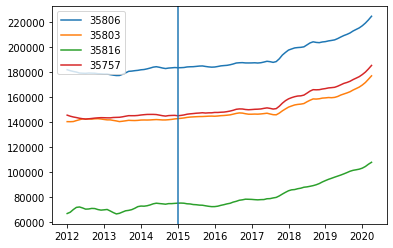

In [419]:
regionID = hsv_cluster_zillowData["RegionName"][0]
regionHomeValue = hsv_cluster_zillowData.iloc[0,dateIndex-36:len(hsv_cluster_zillowData.columns)-1] #hsv_cluster_zillowData.loc[hsv_cluster_zillowData['RegionName']== '35806']
plt.plot(regionHomeValue, label = regionID)

regionID = hsv_cluster_zillowData["RegionName"][1]
regionHomeValue = hsv_cluster_zillowData.iloc[1,dateIndex-36:len(hsv_cluster_zillowData.columns)-1] #hsv_cluster_zillowData.loc[hsv_cluster_zillowData['RegionName']== '35806']
plt.plot(regionHomeValue, label = regionID)

regionID = hsv_cluster_zillowData["RegionName"][2]
regionHomeValue = hsv_cluster_zillowData.iloc[2,dateIndex-36:len(hsv_cluster_zillowData.columns)-1] #hsv_cluster_zillowData.loc[hsv_cluster_zillowData['RegionName']== '35806']
plt.plot(regionHomeValue, label = regionID)

regionID = hsv_cluster_zillowData["RegionName"][3]
regionHomeValue = hsv_cluster_zillowData.iloc[3,dateIndex-36:len(hsv_cluster_zillowData.columns)-1] #hsv_cluster_zillowData.loc[hsv_cluster_zillowData['RegionName']== '35806']
plt.plot(regionHomeValue, label = regionID)
plt.xticks(yearChanges, yearList)

plt.axvline(x=36)
plt.legend()
